In [8]:
from privacy_onion.layer_utils import (
    plot_kde,
    tpr_at_fpr,
    plot_roc,
    plot_kde_lira,
    plot_multi_roc,
    plot_kde_custom,
    tpr_at_threshold)


import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch


In [6]:
os.chdir("../")
plt.style.use("plot_style.mplstyle")

OSError: 'plot_style.mplstyle' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [7]:
MODEL_DIR = f"trained_models/"

In [19]:
pointsvmetrics = {}

## Clipping

### Baseline

In [4]:
exp_ids = ["wrn28-2_CIFAR10_c_10", "fullclip10_aug2","wrn28-2_CIFAR10_c_3" "fullclip3_aug2"]

for exp_id in exp_ids:
    print("=="*50)
    print(exp_id)
    # tpr = tpr_at_fpr(exp_id, fpr=0.001)
    # print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(len(saves['trained_on_indices']))

wrn28-2_CIFAR10_c_10
Accuracy 86.01
25000
fullclip10_aug2
Accuracy 78.94
25000
wrn28-2_CIFAR10_c_3fullclip3_aug2


FileNotFoundError: [Errno 2] No such file or directory: 'trained_models//models/wrn28-2_CIFAR10_c_3fullclip3_aug2/target'

In [ ]:
exp_ids = ["dp_0.01n_10c", "dp_0.1n_10c"]

for exp_id in exp_ids:
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(len(saves['trained_on_indices']))


  attack  tpr_at_fpr_0.001  tps       auc  precision  recall  threshold_at_fpr
0   LiRA            0.0182  455  0.636014   0.949896  0.0182         36.239965
Accuracy 84.73
25000
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.00092   23  0.527531   0.489362  0.00092   

   threshold_at_fpr  
0          8.860886  
Accuracy 75.62
25000


In [11]:
exp_ids = ['CIFAR_selective_l5_3.0','CIFAR_selective_l5_10.0', 'CIFAR_selective_l10_3.0','CIFAR_selective_l10_10.0']


for exp_id in exp_ids:
    print("=="*30)
    print(exp_id)
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(len(saves['trained_on_indices']))




CIFAR_selective_l5_3.0
  attack  tpr_at_fpr_0.001  tps       auc  precision  recall  threshold_at_fpr
0   LiRA            0.0286  715  0.645027   0.967524  0.0286         11.821321
Accuracy 88.11
25000
CIFAR_selective_l5_10.0
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.03108  777  0.653034   0.970037  0.03108   

   threshold_at_fpr  
0         12.103681  
Accuracy 88.98
25000
CIFAR_selective_l10_3.0
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.02104  526  0.634781   0.956364  0.02104   

   threshold_at_fpr  
0          9.505555  
Accuracy 87.90
25000
CIFAR_selective_l10_10.0
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.01868  467  0.635285    0.95112  0.01868   

   threshold_at_fpr  
0         13.208382  
Accuracy 88.68
25000


## Ideal

In [12]:
def filter_ideal(exp_id, layer_folder, layer):
    lira_path = f"{MODEL_DIR}/lira_scores/{exp_id}_target_32"
    df = pd.read_csv(lira_path)


    points_path = f"{MODEL_DIR}/layer_target_indices/{layer_folder}/layer_{layer - 1}_full_safe.pkl"
    full_vuln = pd.read_pickle(points_path)

    filtered = df[df['og_idx'].isin(full_vuln['og_idx'])]
    
    return filtered

In [13]:
ideal_threshold = tpr_at_fpr("CIFAR_top5_l0", 0.001)["threshold_at_fpr"].values[0]

for layer in range(1,7):
    print("=="*50)
    print(f"Layer {layer}")
    df = filter_ideal("CIFAR_top5_l0", "CIFAR_top5", layer)
    print(tpr_at_threshold(df, ideal_threshold))
    

Layer 1


  attack  tpr_at_threshold   tps       auc  precision    recall  threshold
0   LiRA          0.057305  1361  0.698917   0.982671  0.057305   6.494884
Layer 2
  attack  tpr_at_threshold  tps       auc  precision    recall  threshold
0   LiRA          0.038647  872  0.689487   0.973214  0.038647   6.494884
Layer 3
  attack  tpr_at_threshold  tps       auc  precision    recall  threshold
0   LiRA          0.026499  568  0.682866   0.959459  0.026499   6.494884
Layer 4
  attack  tpr_at_threshold  tps       auc  precision    recall  threshold
0   LiRA          0.019348  394  0.677737   0.942584  0.019348   6.494884
Layer 5
  attack  tpr_at_threshold  tps       auc  precision    recall  threshold
0   LiRA          0.015094  292  0.674493   0.924051  0.015094   6.494884
Layer 6
  attack  tpr_at_threshold  tps       auc  precision    recall  threshold
0   LiRA          0.012242  225  0.672009   0.903614  0.012242   6.494884


In [14]:
def filter_points(exp_id, target, layer_folder, layer):
    lira_path = f"{MODEL_DIR}/lira_scores/{exp_id}_{target}_32"
    df = pd.read_csv(lira_path)

    points_path = f"{MODEL_DIR}/layer_target_indices/{layer_folder}/layer_{layer - 1}_full_safe.pkl"
    full_vuln = pd.read_pickle(points_path)
    print(len(full_vuln), "points in full vuln")

    filtered = df[df['og_idx'].isin(full_vuln['og_idx'])]
    path = f"{MODEL_DIR}/lira_scores/{exp_id}_{target}_filt_32"
    filtered.to_csv(path)
    return filtered

In [15]:
# filter_points('ideal', 'CIFAR5_l1', 'wrn28-CIFAR_5', 1)
filter_points('CIFAR_top5_l0', 'target', 'CIFAR_top5', 5)

44346 points in full vuln


,og_idx,lira_score,target_trained_on
0,0,3.171385e+00,True
1,1,2.814173e+00,True
2,2,1.512017e+00,False
3,3,1.994499e+00,True
4,4,2.828670e+00,False
...,...,...,...
49993,49993,2.658444e+00,True
49994,49994,9.951045e-01,False
49995,49995,1.251065e-14,False
49996,49996,6.093117e-02,False


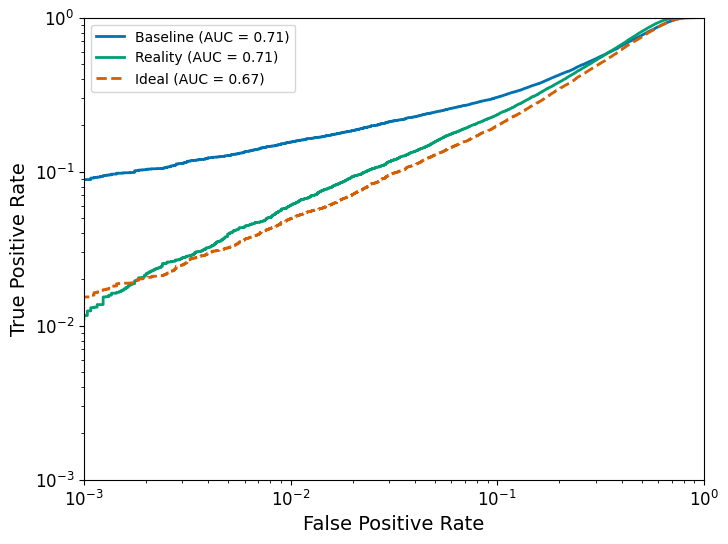

In [16]:
exp_ids = [("CIFAR_top5_l0", "target", "Baseline"),
           ("CIFAR_top5_l5", "target", "Reality"),
           ("CIFAR_top5_l0","target_filt", "Ideal")]


plot_multi_roc(exp_ids)

## Removal and Retrain

### CIFAR10

#### Remove Random 5%

Processing experiment: CIFAR_top5_l0
  attack  tpr_at_fpr_0.001   tps      auc  precision  recall  threshold_at_fpr
0   LiRA            0.0882  2205  0.71007   0.989233  0.0882          6.494884
Accuracy 91.29
Num samples: 25000
Processing experiment: CIFAR10_rand_l1
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.088463  2101  0.713681   0.988706  0.088463   

   threshold_at_fpr  
0          6.288525  
Accuracy 90.50
Num samples: 23750
Processing experiment: CIFAR10_rand_l2
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.073616  1661  0.712034   0.985757  0.073616   

   threshold_at_fpr  
0          7.077027  
Accuracy 90.32
Num samples: 22563
Processing experiment: CIFAR10_rand_l3
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.078936  1692  0.726323   0.986014  0.078936   

   threshold_at_fpr  
0          7.352403  
Accuracy 90.30
Num samples: 21435
Processing expe

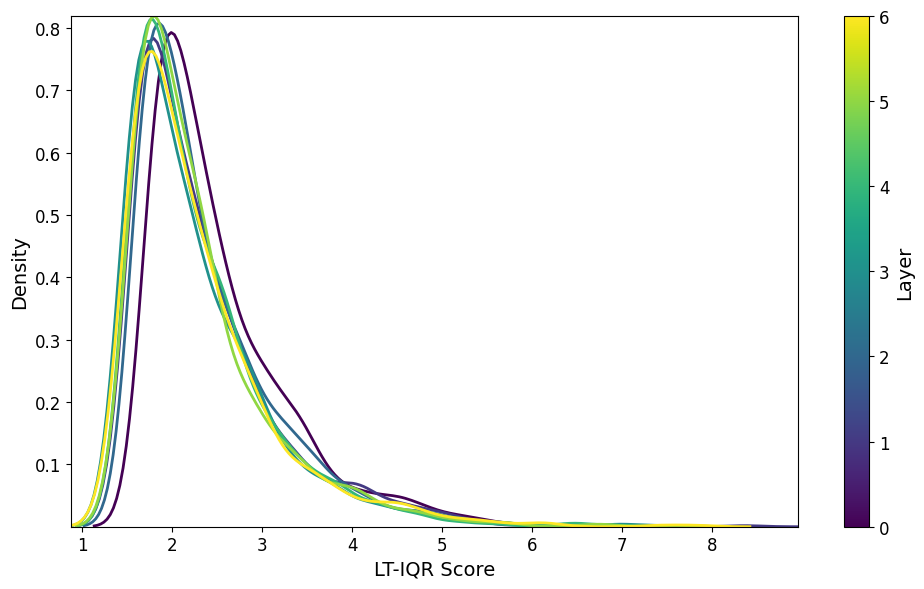

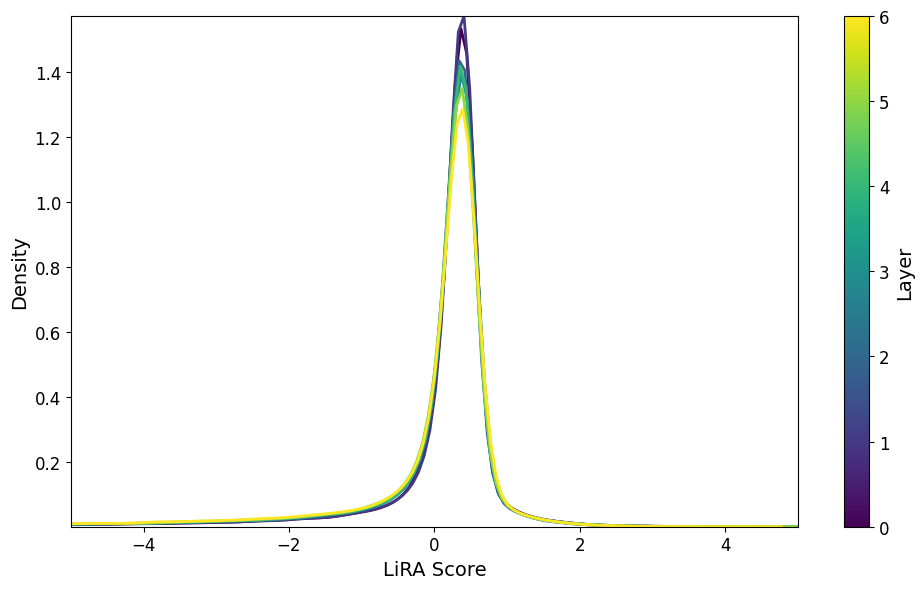

In [20]:
exp_ids = [
    f"CIFAR10_rand_l{layer}" for layer in range(1,7)
]
exp_ids.insert(0, "CIFAR_top5_l0")
for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")
    if "Random 5%" not in pointsvmetrics:
        pointsvmetrics["Random 5%"] = []
    pointsvmetrics["Random 5%"].append({
        "tpr": tpr["tpr_at_fpr_0.001"].iloc[0],
        "acc": saves["test_acc"],
        "num_samples": len(saves["trained_on_indices"]),
    })

plot_kde(exp_ids, save_name="iter_removal_cifar10_rand")
plot_kde_lira(exp_ids, save_name="iter_removal_cifar10_rand_lira")


#### Remove Top 5%

Processing experiment: CIFAR_top5_l0
  attack  tpr_at_fpr_0.001   tps      auc  precision  recall  threshold_at_fpr
0   LiRA            0.0882  2205  0.71007   0.989233  0.0882          6.494884


Accuracy 91.29
Num samples: 25000
Processing experiment: CIFAR_top5_l1
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.050232  1193  0.703017   0.980279  0.050232   

   threshold_at_fpr  
0          7.410028  
Accuracy 90.21
Num samples: 23750
Processing experiment: CIFAR_top5_l2
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.036431  822  0.696149   0.971631  0.036431   

   threshold_at_fpr  
0          6.547515  
Accuracy 88.89
Num samples: 22563
Processing experiment: CIFAR_top5_l3
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.030044  644  0.701728   0.964072  0.030044   

   threshold_at_fpr  
0          6.961058  
Accuracy 87.97
Num samples: 21435
Processing experiment: CIFAR_top5_l4
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.017924  365  0.702919   0.938303  0.017924   

   threshold_at_fpr  
0          7.557461  
Accura

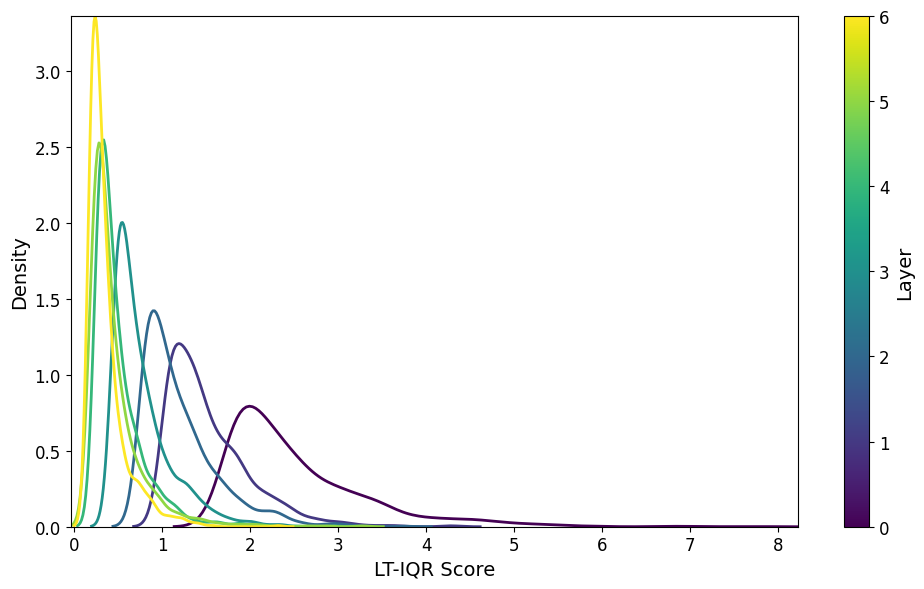

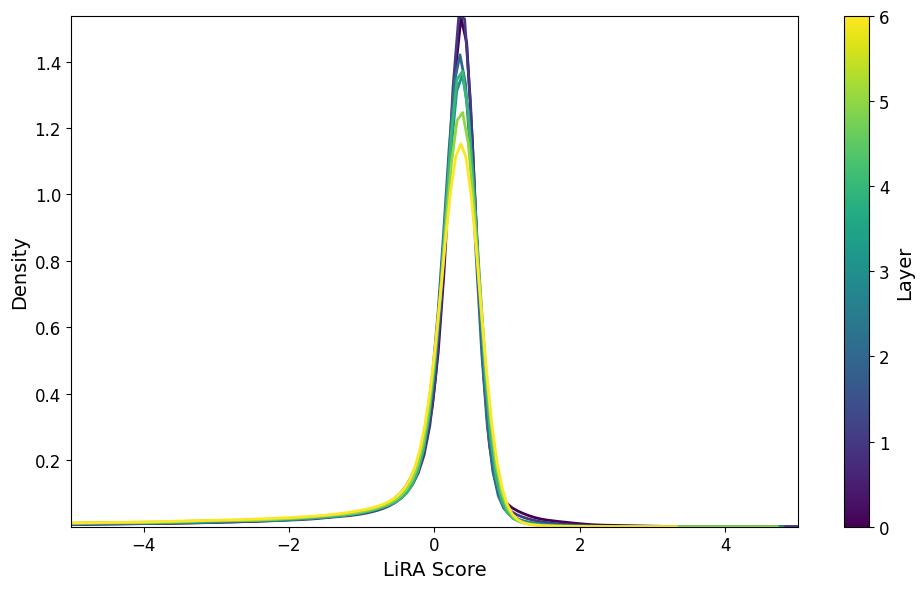

In [21]:
exp_ids = [
    f"CIFAR_top5_l{layer}" for layer in range(7)
]

for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")
    if "Top 5%" not in pointsvmetrics:
        pointsvmetrics["Top 5%"] = []
    pointsvmetrics["Top 5%"].append({
        "tpr": tpr["tpr_at_fpr_0.001"].iloc[0],
        "acc": saves["test_acc"],
        "num_samples": len(saves["trained_on_indices"]),
    })

plot_kde(exp_ids, save_name="iter_removal_cifar5")
plot_kde_lira(exp_ids, save_name="iter_removal_cifar5_lira")


#### Remove Top 2.%

Processing experiment: CIFAR_top5_l0
  attack  tpr_at_fpr_0.001   tps      auc  precision  recall  threshold_at_fpr
0   LiRA            0.0882  2205  0.71007   0.989233  0.0882          6.494884
Accuracy 91.29
Num samples: 25000
Processing experiment: CIFAR_top2_l1
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.065641  1600  0.703087   0.985222  0.065641   

   threshold_at_fpr  
0          6.959772  
Accuracy 90.08
Num samples: 24375
Processing experiment: CIFAR_top2_l2
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.056383  1340  0.705492   0.982405  0.056383   

   threshold_at_fpr  
0          7.176099  
Accuracy 89.74
Num samples: 23766
Processing experiment: CIFAR_top2_l3
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.047126  1092  0.701626   0.978495  0.047126   

   threshold_at_fpr  
0          6.734895  
Accuracy 89.34
Num samples: 23172
Processing experiment

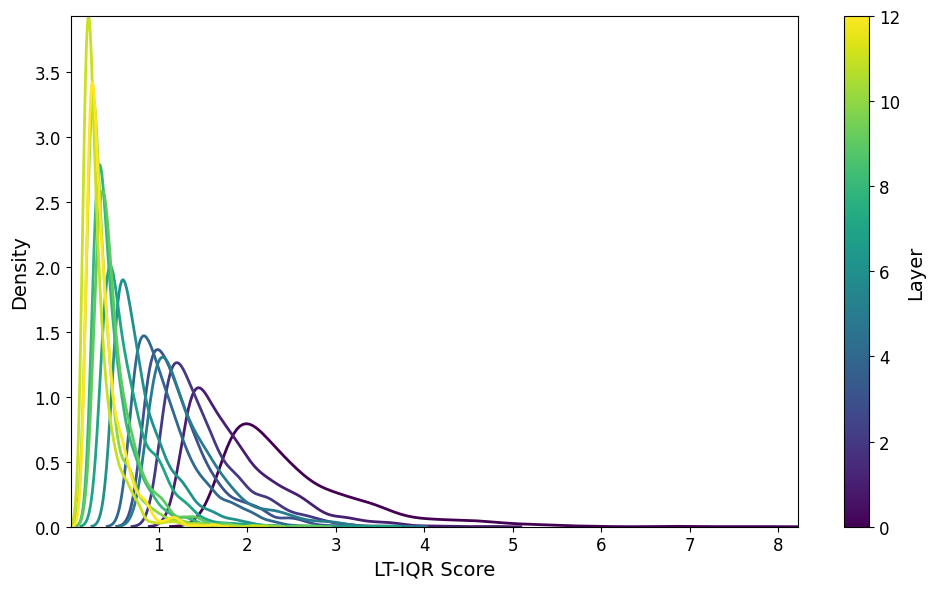

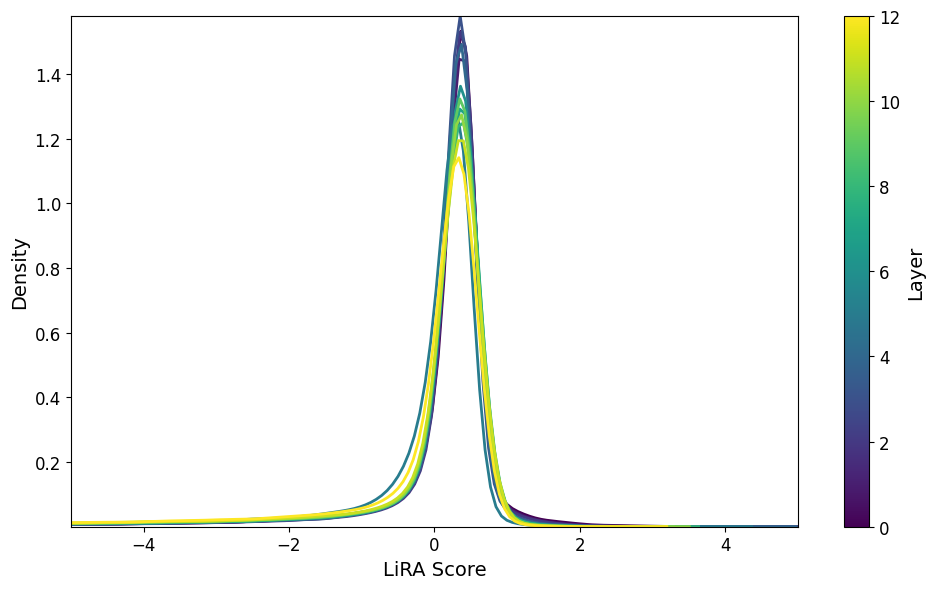

In [22]:
exp_ids = [
    f"CIFAR_top2_l{layer}" for layer in range(1,13)
]
exp_ids.insert(0, "CIFAR_top5_l0")

for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")
    if "Top 2.5%" not in pointsvmetrics:
        pointsvmetrics["Top 2.5%"] = []
    pointsvmetrics["Top 2.5%"].append({
        "tpr": tpr["tpr_at_fpr_0.001"].iloc[0],
        "acc": saves["test_acc"],
        "num_samples": len(saves["trained_on_indices"]),
    })
plot_kde(exp_ids, save_name="iter_removal_cifar2")
plot_kde_lira(exp_ids, save_name="iter_removal_cifar2_lira")


#### Remove Points 2 SD away

Processing experiment: CIFAR_top5_l0
  attack  tpr_at_fpr_0.001   tps      auc  precision  recall  threshold_at_fpr
0   LiRA            0.0882  2205  0.71007   0.989233  0.0882          6.494884
Accuracy 91.29
Num samples: 25000
Processing experiment: CIFAR_sd2_l1


  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.052654  1243  0.701191   0.981058  0.052654   

   threshold_at_fpr  
0          7.035462  
Accuracy 89.83
Num samples: 23607
Processing experiment: CIFAR_sd2_l2
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.028657  639  0.682247   0.963801  0.028657   

   threshold_at_fpr  
0          6.326644  
Accuracy 88.54
Num samples: 22298
Processing experiment: CIFAR_sd2_l3
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.029359  621  0.701489     0.9613  0.029359   

   threshold_at_fpr  
0          6.699375  
Accuracy 88.07
Num samples: 21152
Processing experiment: CIFAR_sd2_l4
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.010868  220  0.681775   0.901639  0.010868   

   threshold_at_fpr  
0          7.277226  
Accuracy 85.89
Num samples: 20243
Processing experiment: CIFAR_sd2_l5
  attack  

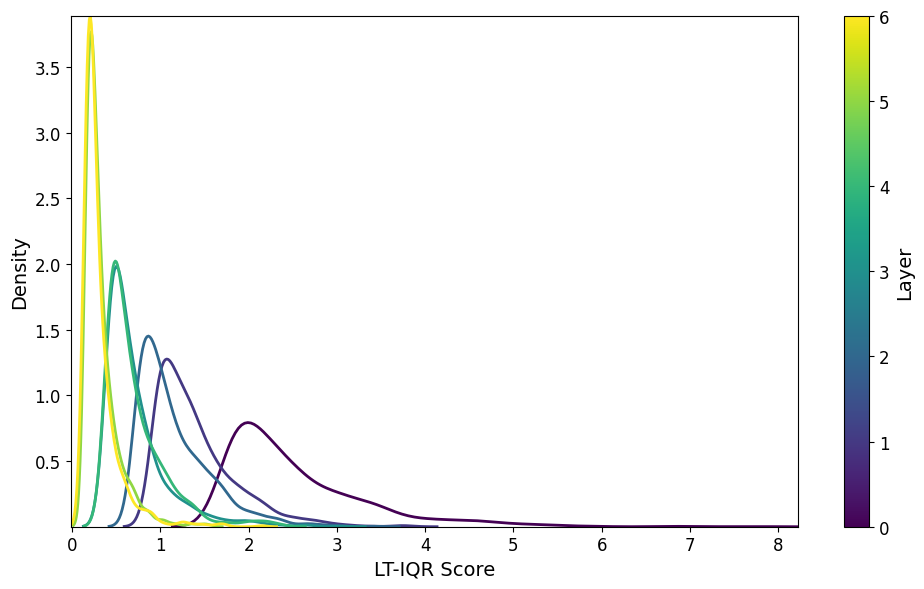

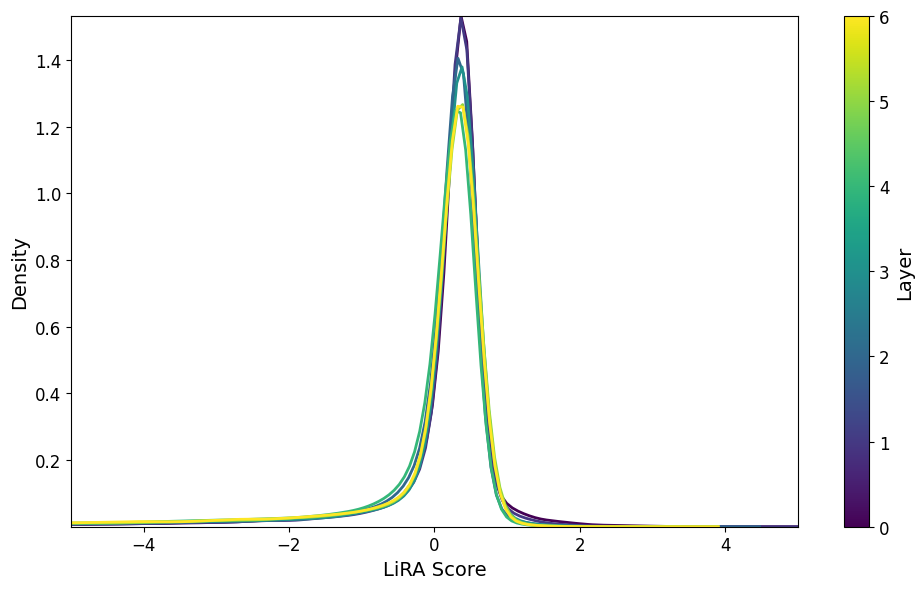

In [23]:
exp_ids = [
    f"CIFAR_sd2_l{layer}" for layer in range(1,7)
]
exp_ids.insert(0, "CIFAR_top5_l0")

for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")
    if "SD 2" not in pointsvmetrics:
        pointsvmetrics["SD 2"] = []
    pointsvmetrics["SD 2"].append({
        "tpr": tpr["tpr_at_fpr_0.001"].iloc[0],
        "acc": saves["test_acc"],
        "num_samples": len(saves["trained_on_indices"]),
    })
plot_kde(exp_ids, save_name="iter_removal_sd2")
plot_kde_lira(exp_ids, save_name="iter_removal_sd2_lira")


#### Remove Points Identified by LiRA

Processing experiment: CIFAR_top5_l0
  attack  tpr_at_fpr_0.001   tps      auc  precision  recall  threshold_at_fpr
0   LiRA            0.0882  2205  0.71007   0.989233  0.0882          6.494884
Accuracy 91.29
Num samples: 25000
Processing experiment: CIFAR_lira_l1
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.01667  380  0.652024   0.940594  0.01667   

   threshold_at_fpr  
0          5.231183  
Accuracy 89.40
Num samples: 22795
Processing experiment: CIFAR_lira_l2
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.025831  579  0.692499   0.960199  0.025831   

   threshold_at_fpr  
0          7.300802  
Accuracy 90.15
Num samples: 22415
Processing experiment: CIFAR_lira_l3
  attack  tpr_at_fpr_0.001  tps       auc  precision  recall  threshold_at_fpr
0   LiRA            0.0147  321  0.691232   0.930435  0.0147          7.269607
Accuracy 89.60
Num samples: 21836
Processing experiment: CIFAR_lira_l4
  attack  t

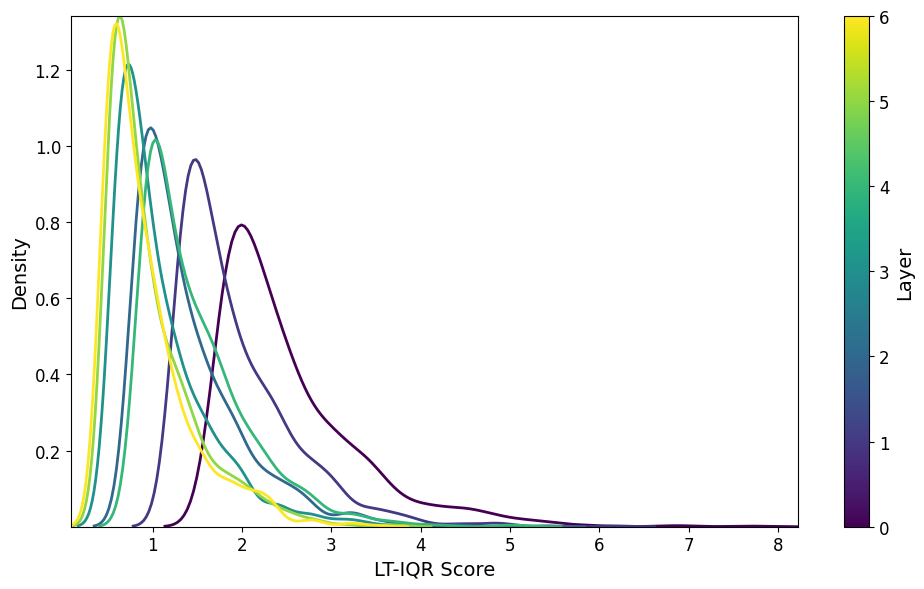

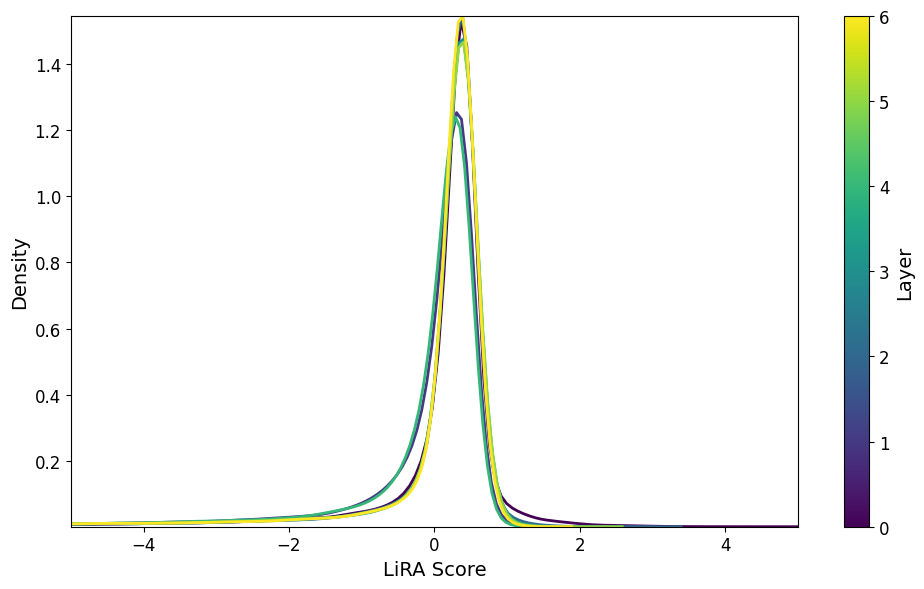

In [33]:
exp_ids = [
    f"CIFAR_lira_l{layer}" for layer in range(1,7)
]
exp_ids.insert(0, "CIFAR_top5_l0")

for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")
    if "LiRA TPs" not in pointsvmetrics:
        pointsvmetrics["LiRA TPs"] = []
    pointsvmetrics["LiRA TPs"].append({
        "tpr": tpr["tpr_at_fpr_0.001"].iloc[0],
        "acc": saves["test_acc"],
        "num_samples": len(saves["trained_on_indices"]),
    })
    
plot_kde(exp_ids, save_name="iter_removal_lira")
plot_kde_lira(exp_ids, save_name="iter_removal_lirarem_lira")


### CINIC10

#### Remove Top 5%

In [ ]:
exp_ids = [
    f"CINIC_top5_l{layer}" for layer in range(1,7)
]
trained_points = {}
for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    trained_points[exp_id] = saves['trained_on_indices']
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")

Processing experiment: CINIC_top5_l1
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.076094  3253  0.763718   0.986655  0.076094   

   threshold_at_fpr  
0          7.298571  
Accuracy 80.66
Num samples: 42750
Processing experiment: CINIC_top5_l2
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.061729  2507  0.758592   0.982752  0.061729   

   threshold_at_fpr  
0          6.880382  
Accuracy 80.17
Num samples: 40613
Processing experiment: CINIC_top5_l3
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.047534  1834  0.756251   0.976571  0.047534   

   threshold_at_fpr  
0          7.050756  
Accuracy 79.27
Num samples: 38583
Processing experiment: CINIC_top5_l4
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.033803  1239  0.749528   0.965705  0.033803   

   threshold_at_fpr  
0          7.214996  
Accuracy 78.30
Num samples: 36654


## Selective Clipping

### Baseline Clipping and DP

Processing experiment: wrn28-2_CIFAR10_c_10
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.02832  708  0.656494   0.967213  0.02832   

   threshold_at_fpr  
0         74.792133  
Accuracy 86.01
Processing experiment: wrn28-2_CIFAR10_c_5
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.01348  337  0.636401   0.933518  0.01348   

   threshold_at_fpr  
0         45.092687  
Accuracy 84.05
Processing experiment: wrn28-2_CIFAR10_c_3
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.00776  194  0.620119   0.889908  0.00776   

   threshold_at_fpr  
0         20.596763  
Accuracy 82.38


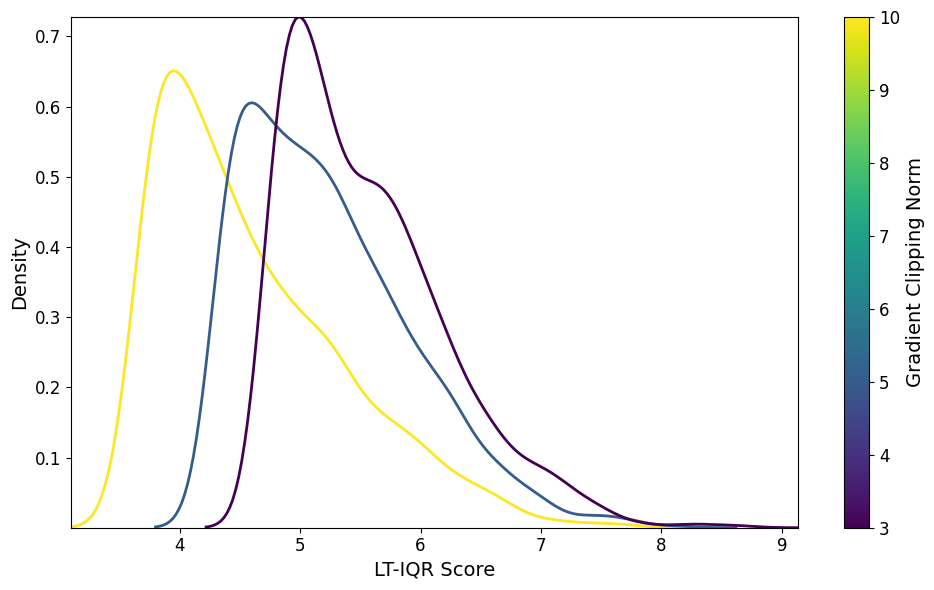

In [ ]:
exp_ids = ["wrn28-2_CIFAR10_c_10", "wrn28-2_CIFAR10_c_5", "wrn28-2_CIFAR10_c_3"]

for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    # plot_roc(exp_id, fpr=0.001, tpr=0.9, plot=True)
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")

plot_kde_custom(exp_ids, labels=[10,5,3 ], label_name="Gradient Clipping Norm", save_name="cifar10_clipping")


### DP

In [36]:
# first one is 512,4 
exp_ids = ["CIFAR_dp_no_multaug","test_multaug", "dp_augmult_1024_8aug", "dp_augmult_2048_16aug", "augmult_clip_10"]
for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    # tpr = tpr_at_fpr(exp_id, fpr=0.001)
    # print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/model", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")




Processing experiment: CIFAR_dp_no_multaug
Accuracy 52.47
Num samples: 25000
Processing experiment: test_multaug
Accuracy 61.03
Num samples: 25000
Processing experiment: dp_augmult_1024_8aug
Accuracy 66.03
Num samples: 25000
Processing experiment: dp_augmult_2048_16aug
Accuracy 65.01
Num samples: 25000
Processing experiment: augmult_clip_10
Accuracy 71.18
Num samples: 25000


### Selective Clipping

In [32]:
exp_ids = ['CIFAR_GN_test']


for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    # tpr = tpr_at_fpr(exp_id, fpr=0.001)
    # print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")




Processing experiment: CIFAR_GN_test
Accuracy 88.92
Num samples: 25000


In [3]:
exp_ids = ['CIFAR_selective_l1_3.0','CIFAR_selective_l5_10.0', 'CIFAR_selective_l10_3.0','CIFAR_selective_l10_10.0', 'CIFAR_selective_l20_10.0', 'CIFAR_selective_l20_3.0']


for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")

# plot_kde_custom(exp_ids, labels=[10,5,3 ], label_name="Gradient Clipping Norm", save_name="cifar10_clipping")




Processing experiment: CIFAR_selective_l1_3.0
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.029558  702  0.657617   0.966942  0.029558   

   threshold_at_fpr  
0         16.580947  
Accuracy 88.11
Num samples: 23750
Processing experiment: CIFAR_selective_l5_10.0
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.029937  711  0.660779   0.967347  0.029937   

   threshold_at_fpr  
0         17.913754  
Accuracy 88.98
Num samples: 23750
Processing experiment: CIFAR_selective_l10_3.0
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.023956  539  0.665908   0.957371  0.023956   

   threshold_at_fpr  
0         17.506258  
Accuracy 87.90
Num samples: 22500
Processing experiment: CIFAR_selective_l10_10.0
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.022889  515  0.654871   0.955473  0.022889   

   threshold_at_fpr  
0         20.613516  
Ac

In [8]:
exp_ids = ["CIFAR_dp_50ep_10c"]
import torch
for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    # plot_roc(exp_id, fpr=0.001, tpr=0.9, plot=True)
    # tpr = tpr_at_fpr(exp_id, fpr=0.001)
    # print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/shadow_1", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")




Processing experiment: CIFAR_dp_50ep_10c
Accuracy 51.33


## Trained Points vs Acc and TPR

In [32]:
pointsvmetrics.pop('LiRA TPs')

[{'exp_id': 'CIFAR_top5_l0',
  'tpr':   attack  tpr_at_fpr_0.001   tps      auc  precision  recall  threshold_at_fpr
  0   LiRA            0.0882  2205  0.71007   0.989233  0.0882          6.494884,
  'accuracy': 91.29,
  'num_samples': 25000},
 {'exp_id': 'CIFAR_lira_l1',
  'tpr':   attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
  0   LiRA           0.01667  380  0.652024   0.940594  0.01667   
  
     threshold_at_fpr  
  0          5.231183  ,
  'accuracy': 89.4,
  'num_samples': 22795},
 {'exp_id': 'CIFAR_lira_l2',
  'tpr':   attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
  0   LiRA          0.025831  579  0.692499   0.960199  0.025831   
  
     threshold_at_fpr  
  0          7.300802  ,
  'accuracy': 90.15,
  'num_samples': 22415},
 {'exp_id': 'CIFAR_lira_l3',
  'tpr':   attack  tpr_at_fpr_0.001  tps       auc  precision  recall  threshold_at_fpr
  0   LiRA            0.0147  321  0.691232   0.930435  0.0147          7.269607,
  'accuracy': 89.6,

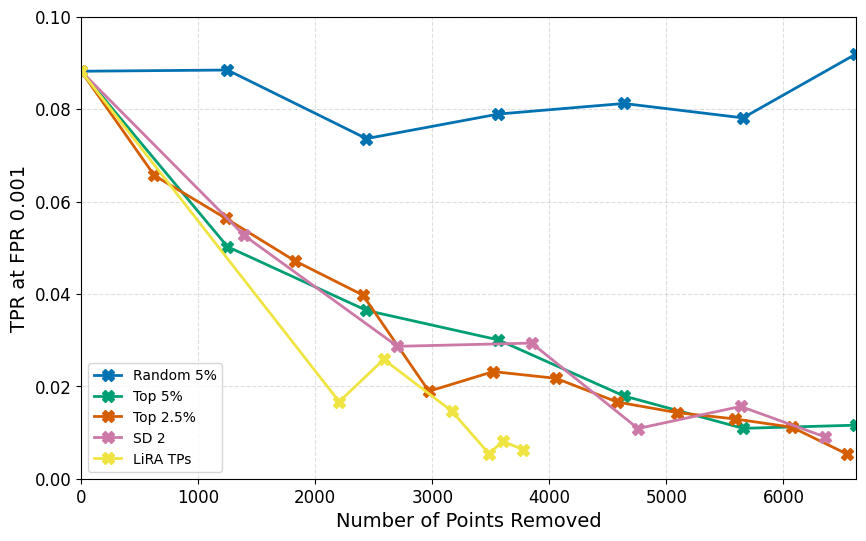

In [43]:

plt.figure(figsize=(10, 6))
for label, metrics in pointsvmetrics.items():
    tpr_values = [m["tpr"] for m in metrics]
    num_samples = [25000 - m["num_samples"] for m in metrics]
    plt.plot(num_samples, tpr_values, marker='X', label=label, markersize=9, alpha=1)
plt.xlabel("Number of Points Removed")
plt.ylabel("TPR at FPR 0.001")
plt.legend()
plt.ylim(0,0.1)    
plt.grid(linestyle='--', alpha=0.4)
plt.savefig("./figures/pointsvstpr.png", bbox_inches='tight', dpi=300)



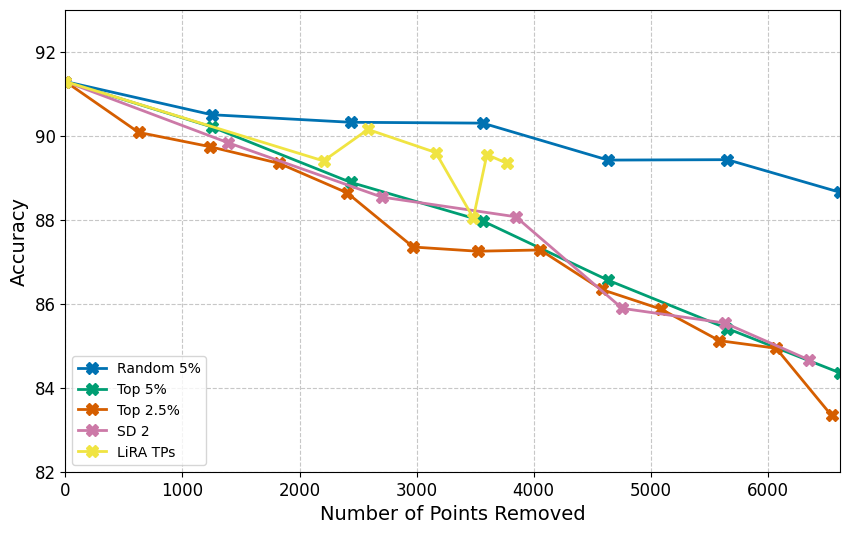

In [ ]:

plt.figure(figsize=(10, 6))
for label, metrics in pointsvmetrics.items():
    acc = [m["acc"] for m in metrics]
    num_samples = [25000 - m["num_samples"] for m in metrics]
    plt.plot(num_samples, acc, marker='X', label=label, markersize=9)
plt.xlabel("Number of Points Removed")
plt.ylabel("Accuracy")
plt.ylim(82, 93)
plt.legend(loc='lower left')
plt.grid(linestyle='--', alpha=0.7)
plt.savefig("./figures/pointsvacc.png", bbox_inches='tight', dpi=300)